# scRNA-Seq dataset [Candeli et al. (2025)](https://www....)

Single cell transcriptome analysis of NEr-fAOs

Show that while enriched for PNECs, NEr-fAOs retain diverse airway cell types, preserving epithelial complexity. We map PNEC trajectories in NEr-fAOs, uncovering precursor and mature states. Comparative analyses show that basal stem cells in NEr-fAOs acquire lower airway progenitor (LAP)-like signatures.

### Imports

In [1]:
import scvelo as scv
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import os, tqdm
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import csv
from gtfparse import read_gtf
import hdf5plugin
import seaborn as sns
import scanpy.external as sce
from scipy.sparse import coo_matrix
import scipy
from scipy import sparse
from bioinfokit import analys, visuz
from sanbomics.plots import volcano
from adjustText import adjust_text
import leidenalg
import gseapy
import decoupler
from scipy import io
import anndata as ad
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib as mpl
from scipy.sparse import csr_matrix
import harmonypy as hm
import celltypist
from celltypist import models

### Figure Settings

In [2]:
# Set font types to ensure text is editable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42   # For PDF export
mpl.rcParams['ps.fonttype'] = 42    # For PS export
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.dpi'] = 600

# Scanpy figure settings
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, 
                     frameon=False, vector_friendly=True, fontsize=12, 
                     figsize=(5,4), color_map=None, format='pdf', facecolor=None, 
                     transparent=False, ipython_format='png')

# scVelo figure settings
scv.set_figure_params(style='scvelo', dpi=80, dpi_save=600, 
                      frameon=False, vector_friendly=True, transparent=True, fontsize=12, 
                      figsize=(5,4), color_map=None, facecolor=None, format='pdf', ipython_format='png')

# Set figure directory
sc.settings.figdir = './../figures/'
scv.settings.figdir = './../figures/'

figfolder='./../figures/'

# Fine-tune Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['figure.subplot.wspace'] = 0.99
plt.rcParams['axes.grid'] = False

import logging
# Suppress INFO messages
logging.getLogger("fontTools").setLevel(logging.WARNING)
plt.set_loglevel('WARNING') 

### Custom colormap

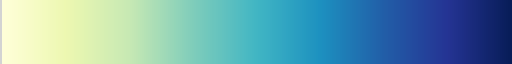

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Define the 'lightgrey' color as an RGBA tuple with values in the range 0-1
lightgrey_rgba = (0.83, 0.83, 0.83, 1.0)  # RGB values for lightgrey with alpha=1.0
# Get the 'YlGnBu' colormap
YlGnBu_cmap = plt.cm.get_cmap('YlGnBu')
# Define the number of steps for interpolation
num_steps = 256
# Define the range for values where lightgrey is used
lightgrey_range = 0.0
# Interpolate between light grey and blue for values from 0 to lightgrey_range
interpolated_colors_below = [lightgrey_rgba] + [YlGnBu_cmap(i) for i in np.linspace(0, 1, int(num_steps * lightgrey_range))]
# Interpolate between light grey and green for values from lightgrey_range to 1
interpolated_colors_above = [YlGnBu_cmap(i) for i in np.linspace(0, 1, int(num_steps * (1 - lightgrey_range)))]
# Combine the two sets of colors
interpolated_colors = interpolated_colors_below + interpolated_colors_above
# Create the custom colormap
cmap = LinearSegmentedColormap.from_list('custom_YlGnBu', interpolated_colors)
# Now you can use this custom colormap in your plots
cmap

### Inspect matrixes AnnData

In [4]:
import numpy as np
from scipy.sparse import issparse

def matrix_summary(adata):
    """
    Prints min, max, and mean for expression matrix, counts layer, raw matrix,
    and scaled layer of an AnnData object.

    Parameters:
        adata: AnnData
    """

    # Helper function to compute min, max, mean
    def summary(matrix, name):
        if issparse(matrix):
            matrix = matrix.toarray()
        flat = matrix.flatten()
        mean_value = flat.mean()
        print(f"{name}: min={flat.min()}, max={flat.max()}, mean={mean_value}")

    # Expression matrix
    summary(adata.X, "Expression matrix (X)")

    # Counts layer
    if 'counts' in adata.layers:
        summary(adata.layers['counts'], "Counts layer matrix (layers['counts'])")
    else:
        print("Counts layer not found in adata.layers.")

    # Raw matrix
    if adata.raw is not None:
        summary(adata.raw.X, "Raw matrix (raw.X)")
    else:
        print("Raw matrix not found in adata.raw.")

    # Scaled layer
    if 'scaled' in adata.layers:
        summary(adata.layers['scaled'], "Scaled layer matrix (layers['scaled'])")
    else:
        print("Scaled layer not found in adata.layers.")


# PREPROCESSING

In [5]:
adata=sc.read_h5ad('./../data/STARsolo.velocyto_NEr-fAOs.h5ad')
adata

AnnData object with n_obs × n_vars = 5817 × 32245
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week'
    var: 'gene_ids', 'feature_types', 'n_cells'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [6]:
sample_ids = adata.obs['Sample ID'].unique()
print(sample_ids)

['s003', 's002', 's027', 's026', 's001', ..., 's063', 's090', 's035', 's004', 's007']
Length: 23
Categories (23, object): ['s001', 's002', 's003', 's004', ..., 's084', 's086', 's090', 's092']


In [7]:
media_ids = adata.obs['Media'].unique()
print(media_ids)

['Standard', 'NE Expansion', 'NE Differentiation']
Categories (3, object): ['NE Differentiation', 'NE Expansion', 'Standard']


In [8]:
time_ids = adata.obs['Time point'].unique()
print(time_ids)

['day0-std', 'day0', 'day1', 'day3', 'day10']
Categories (5, object): ['day0', 'day0-std', 'day1', 'day3', 'day10']


In [9]:
patient_ids = adata.obs['Patient ID'].unique()
print(patient_ids)

['124e', '125e', '119e']
Categories (3, object): ['119e', '124e', '125e']


In [10]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var

,gene_ids,feature_types,n_cells
ENSG00000238009,ENSG00000238009.6,Gene Expression,28
CICP27,ENSG00000233750.3,Gene Expression,18
ENSG00000268903,ENSG00000268903.1,Gene Expression,170
ENSG00000241860,ENSG00000241860.7,Gene Expression,74
ENSG00000241599,ENSG00000241599.1,Gene Expression,4
...,...,...,...
MT-ND6,ENSG00000198695.2,Gene Expression,1691
MT-TE,ENSG00000210194.1,Gene Expression,85
MT-CYB,ENSG00000198727.2,Gene Expression,5554
MT-TT,ENSG00000210195.2,Gene Expression,107


In [11]:
#Find Gene dataset
adata.var
df = pd.DataFrame(adata.var)
var_names=["ASCL1","CHGA","UCHL1","NEUROD1","INSM1","NEUROG3"]
df = df[df.index.isin(var_names)]
df

,gene_ids,feature_types,n_cells
NEUROD1,ENSG00000162992.5,Gene Expression,482
UCHL1,ENSG00000154277.13,Gene Expression,715
NEUROG3,ENSG00000122859.5,Gene Expression,179
ASCL1,ENSG00000139352.4,Gene Expression,881
CHGA,ENSG00000100604.13,Gene Expression,317
INSM1,ENSG00000173404.5,Gene Expression,747


In [12]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [13]:
adata.var['rp'] = adata.var_names.str.startswith('RP')  # annotate the group of ribosomal genes as 'rp'
sc.pp.calculate_qc_metrics(adata, qc_vars=['rp'], percent_top=None, log1p=False, inplace=True)

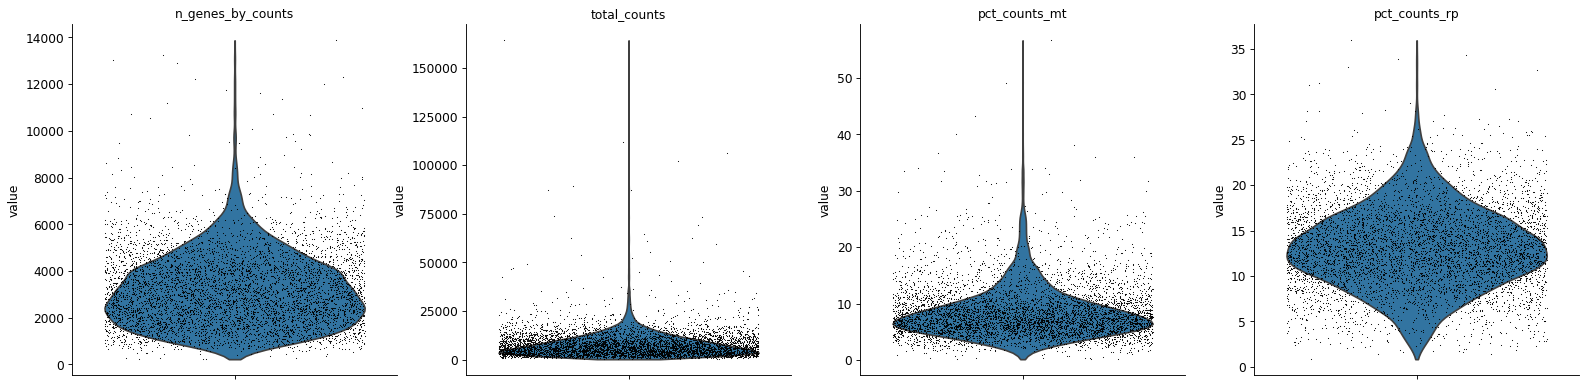

In [14]:
sc.pl.violin(adata,['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_rp'],jitter=0.4, multi_panel=True)

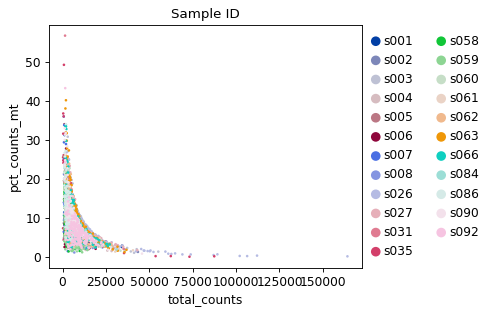

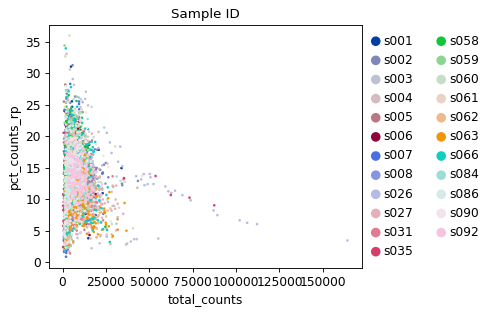

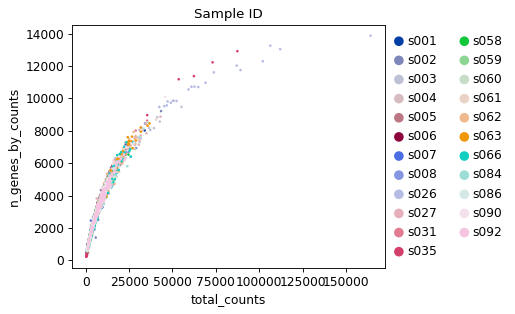

In [15]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',color='Sample ID')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_rp',color='Sample ID')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',color='Sample ID')

## Filetring
Remove potential multiplets (cells with more high total counts: above the 99.5th percentile)
Remove possible empty droplets (cells with less than 1000 counts)
Remove low-quality cells with too few detected genes (cells with less than 500 genes)
Remove cells with more than 25% of MT genes expressed.

In [16]:
# Filtering
# Potential multiplets
upper = np.percentile(adata.obs.total_counts, 99.5)
adata = adata[adata.obs.total_counts <= upper, :].copy()
# Potential empty droplets
adata = adata[adata.obs.total_counts  >= 1000, :].copy()
adata = adata[adata.obs.n_genes_by_counts >= 500, :].copy()
# Cells expressing too many MT genes
adata = adata[adata.obs.pct_counts_mt <= 25, :].copy()

adata

AnnData object with n_obs × n_vars = 5441 × 32191
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp'
    uns: 'Sample ID_colors'
    layers: 'ambiguous', 'spliced', 'unspliced'

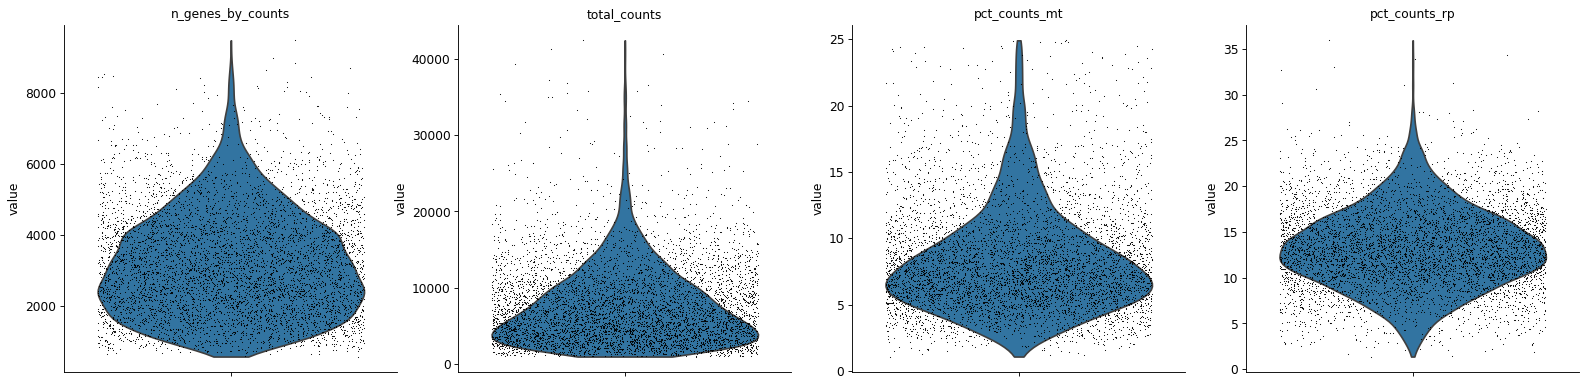

In [17]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_rp'],
             jitter=0.4, multi_panel=True)

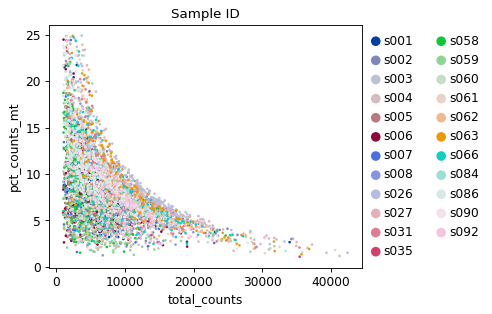

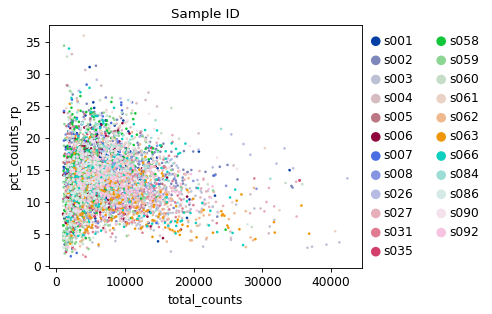

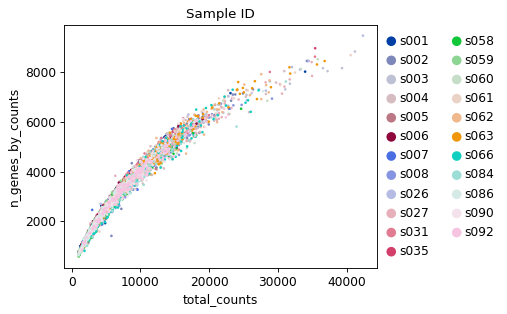

In [18]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',color='Sample ID')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_rp',color='Sample ID')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',color='Sample ID')

## Normalization & Highly Variable Genes

In [128]:
# Save counts layer
adata.layers["counts"] = adata.X.copy()

# Normalize counts per cell.
# Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization
sc.pp.normalize_total(adata, target_sum=1e4)

#Logarithmize the data matrix.
#Computes X = log (X=1), where X denotes the natural logarithm unless a different base is given.
sc.pp.log1p(adata)

adata.raw = adata.copy()
adata

AnnData object with n_obs × n_vars = 5441 × 32191
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp'
    uns: 'Sample ID_colors', 'log1p'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

In [129]:
#Inspect Matrices
matrix_summary(adata)

Expression matrix (X): min=0.0, max=6.779815196990967, mean=0.11133979260921478


Counts layer matrix (layers['counts']): min=0.0, max=150.0, mean=0.2390950471162796


Raw matrix (raw.X): min=0.0, max=6.779815196990967, mean=0.11133979260921478
Scaled layer not found in adata.layers.


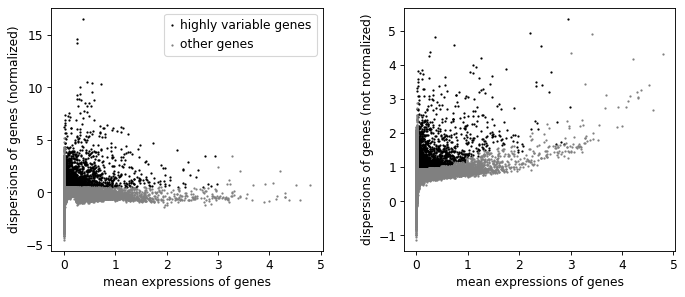

In [130]:
# highly-variable genes are selected
sc.pp.highly_variable_genes(adata, layer=None, n_top_genes=None, min_disp=0.5, min_mean=0.0125,
                                max_mean=3, span=0.3, n_bins=20, flavor='seurat', 
                                subset=False, inplace=True,batch_key=None, check_values=True)
sc.pl.highly_variable_genes(adata)

## Regress out (mostly) unwanted sources of variation.

In [131]:
# Parsing of Cell Cycle genes file
cell_cycle_genes = [x.strip() for x in open ('./../data/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [132]:
# Score all genes using our S and G2M phase gene lists
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

... storing 'phase' as categorical


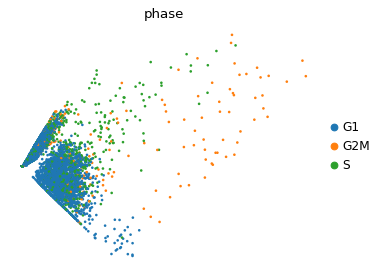

In [133]:
# We will plot the PCA of the cell cycle genes' source of variation
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color= 'phase')

... storing 'phase' as categorical


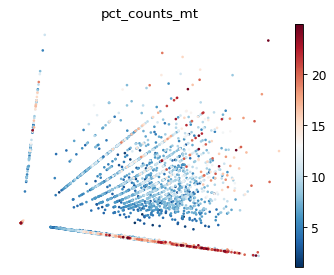

In [134]:
# We will plot the PCA of the mitochondrial genes' source of variation
adata_mt_genes = adata[:, adata.var_names.str.startswith('MT-')]
sc.tl.pca(adata_mt_genes)
sc.pl.pca_scatter(adata_mt_genes, color='pct_counts_mt')

... storing 'phase' as categorical


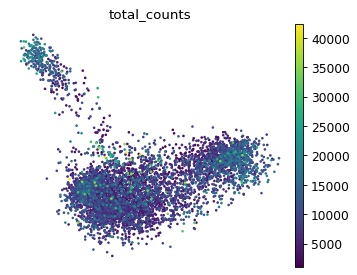

In [135]:
# We will plot the PCA of the total counts' source of variation
adata_hvg = adata[:, adata.var['highly_variable']]
sc.tl.pca(adata_hvg)
sc.pl.pca_scatter(adata_hvg, color='total_counts', cmap='viridis')

In [136]:
# Regress out the unwanted sources of variation.
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt",'S_score','G2M_score'])

... storing 'phase' as categorical


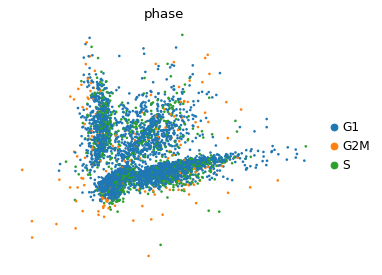

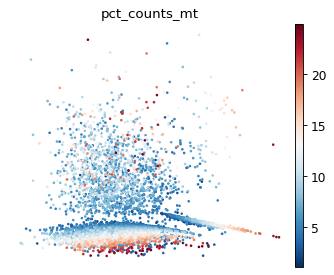

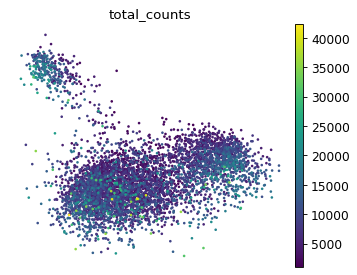

In [137]:
# Plot PCA again after regression
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color= 'phase')
adata_mt_genes = adata[:, adata.var_names.str.startswith('MT-')]
sc.tl.pca(adata_mt_genes)
sc.pl.pca_scatter(adata_mt_genes, color='pct_counts_mt')
adata_hvg = adata[:, adata.var['highly_variable']]
sc.tl.pca(adata_hvg)
sc.pl.pca_scatter(adata_hvg, color='total_counts', cmap='viridis')

In [138]:
#Inspect Matrices
matrix_summary(adata)

Expression matrix (X): min=-4.794265270233154, max=5.643955707550049, mean=9.511085252711382e-10


Counts layer matrix (layers['counts']): min=0.0, max=150.0, mean=0.2390950471162796


Raw matrix (raw.X): min=0.0, max=6.779815196990967, mean=0.11133979260921478
Scaled layer not found in adata.layers.


## Scaling of the data

In [139]:
# Scale data to unit variance and zero mean store results in layer
# Variables (genes) that do not display any variation (are constant across all observations) 
# are retained and set to 0 during this operation. In the future, they might be set to NaNs.

adata.layers["scaled"] = sc.pp.scale(adata, copy=True).X.copy()
adata

AnnData object with n_obs × n_vars = 5441 × 32191
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Sample ID_colors', 'log1p', 'hvg'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts', 'scaled'

In [140]:
#Inspect Matrices
matrix_summary(adata)

Expression matrix (X): min=-4.794265270233154, max=5.643955707550049, mean=9.511085252711382e-10


Counts layer matrix (layers['counts']): min=0.0, max=150.0, mean=0.2390950471162796


Raw matrix (raw.X): min=0.0, max=6.779815196990967, mean=0.11133979260921478
Scaled layer matrix (layers['scaled']): min=-13.424216270446777, max=73.74729919433594, mean=1.9892476554872474e-09


## Compute PCA

In [141]:
sc.tl.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

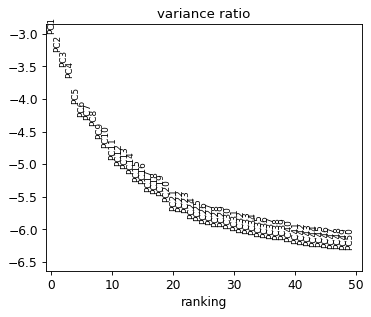

In [142]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)

In [143]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=25)
sc.tl.draw_graph(adata)

2026-01-07 00:54:56.137385: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-07 00:54:56.137492: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-07 00:54:56.695046: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2026-01-07 00:54:58.657276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [144]:
# Define a Time point colors
time_colours = ['#F9C74F','#F8766D','#7CAE00','#00BFC4','#C77CFF']
# Define a media colors
media_colours = ['#F9C74F','#FF7F71','#555555']

In [145]:
custom_order = ['day0-std','day0','day1','day3','day10']
custom_dtype = pd.CategoricalDtype(categories=custom_order, ordered=True)
adata.obs['Time point'] = adata.obs['Time point'].astype(custom_dtype)
adata.uns['Time point_colors']=time_colours

In [146]:
custom_order = ['Standard','NE Expansion','NE Differentiation']
custom_dtype = pd.CategoricalDtype(categories=custom_order, ordered=True)
adata.obs['Media'] = adata.obs['Media'].astype(custom_dtype)
adata.uns['Media_colors']=media_colours

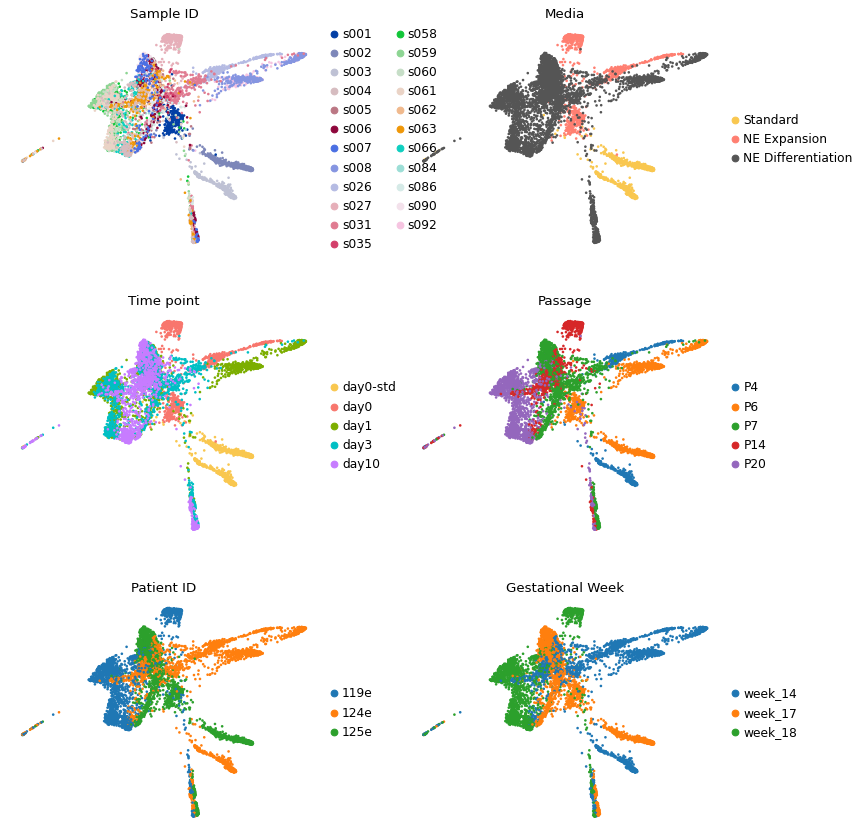

In [147]:
sc.pl.draw_graph(adata, color=['Sample ID','Media',
                               'Time point','Passage',
                               'Patient ID', 'Gestational Week'],
                 ncols=2,save='_Std_NE_Exp_Diff_NOT_harmonized')

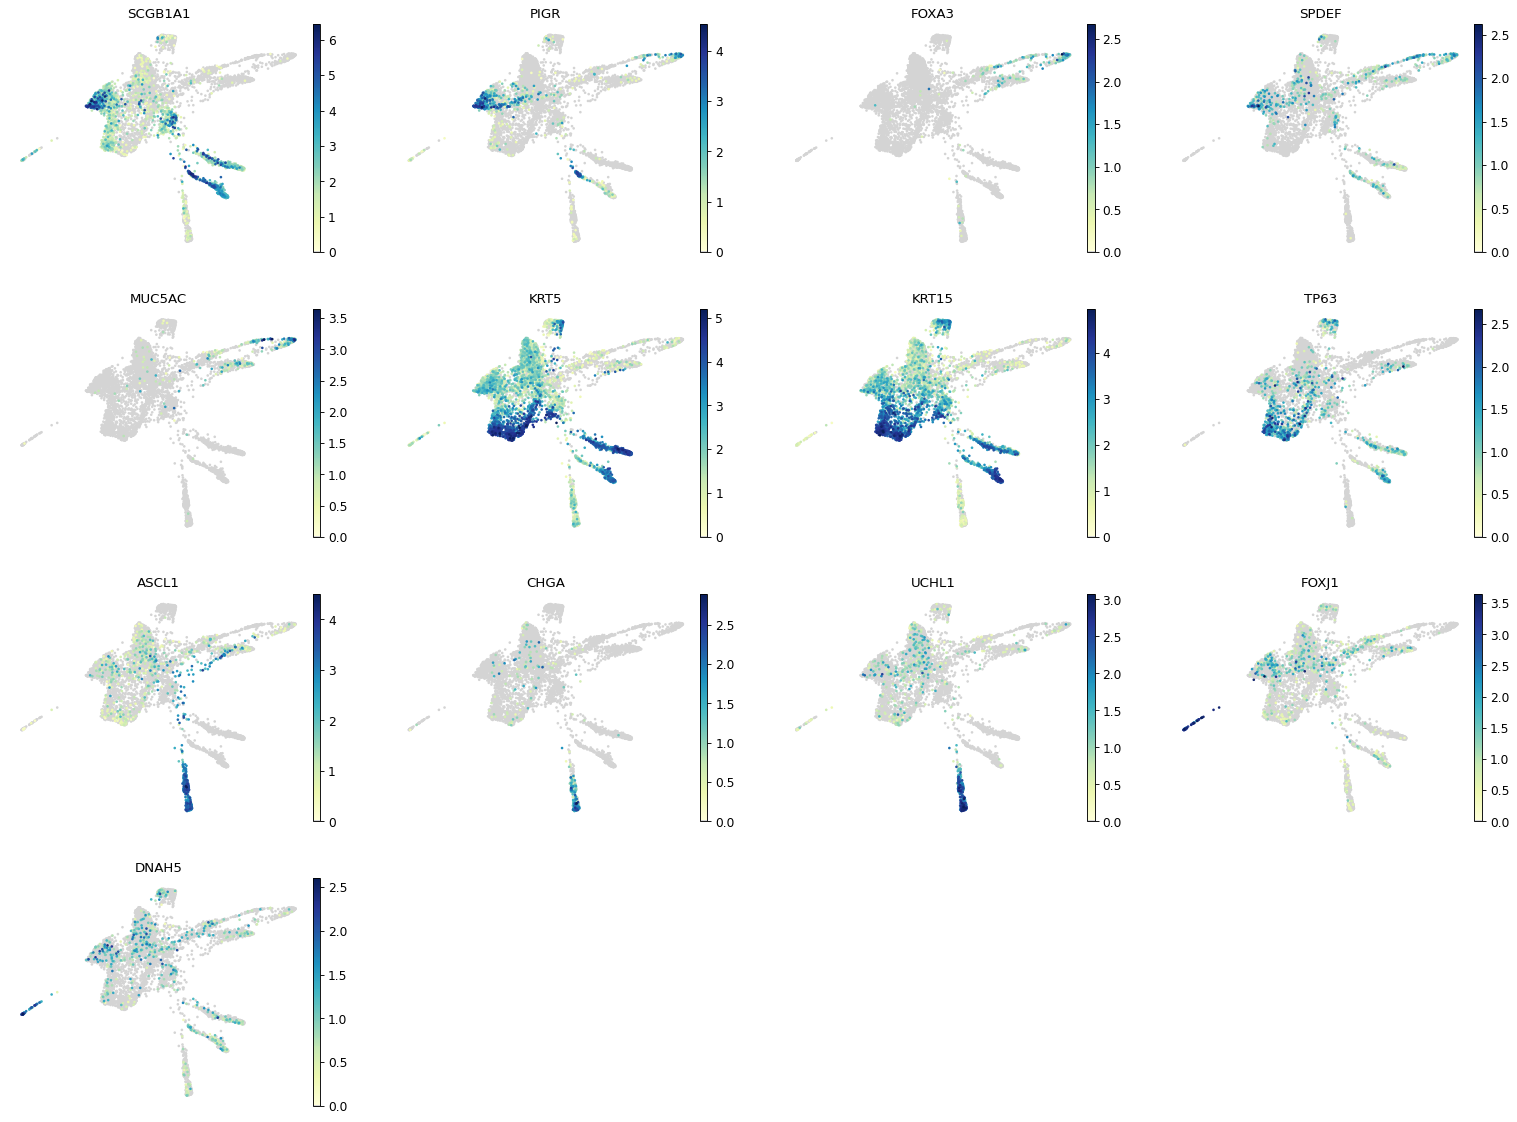

In [148]:
# Plot expression of cell-type markers on the force-directed graph
sc.pl.draw_graph(
    adata,
    use_raw=True,
    color=[
        # --- Club markers ---
        'SCGB1A1', 'PIGR',
        # --- Goblet markers ---
        'FOXA3', 'SPDEF', 'MUC5AC',
        # --- Basal markers ---
        'KRT5', 'KRT15', 'TP63',
        # --- Neuroendocrine markers ---
        'ASCL1', 'CHGA', 'UCHL1',
        # --- Ciliated markers ---
        'FOXJ1', 'DNAH5'
    ],
    cmap=cmap,
    vmin=1e-10
)

In [149]:
adata.write_h5ad('./../data/NEr_fAOs.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

# Harmony Integration
def run_harmony(
    max_iter_harmony = 50,
    epsilon_cluster = -Inf,
    epsilon_harmony = -Inf, 
    plot_convergence = True
)

In [150]:
adata=sc.read_h5ad('./../data/NEr_fAOs.h5ad')
adata

AnnData object with n_obs × n_vars = 5441 × 32191
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Gestational Week_colors', 'Media_colors', 'Passage_colors', 'Patient ID_colors', 'Sample ID_colors', 'Time point_colors', 'draw_graph', 'hvg', 'log1p', 'neighbors', 'pca'
    obsm: 'X_draw_graph_fa', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'counts', 'scaled', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [151]:
sc.external.pp.harmony_integrate(adata, ['Sample ID'], basis='X_pca', adjusted_basis='X_pca_harmony')

2026-01-07 00:55:47,046 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


2026-01-07 00:55:48,065 - harmonypy - INFO - sklearn.KMeans initialization complete.


INFO:harmonypy:sklearn.KMeans initialization complete.


2026-01-07 00:55:48,091 - harmonypy - INFO - Iteration 1 of 50


INFO:harmonypy:Iteration 1 of 50


2026-01-07 00:55:48,901 - harmonypy - INFO - Iteration 2 of 50


INFO:harmonypy:Iteration 2 of 50


2026-01-07 00:55:49,710 - harmonypy - INFO - Iteration 3 of 50


INFO:harmonypy:Iteration 3 of 50


2026-01-07 00:55:50,516 - harmonypy - INFO - Iteration 4 of 50


INFO:harmonypy:Iteration 4 of 50


2026-01-07 00:55:51,259 - harmonypy - INFO - Iteration 5 of 50


INFO:harmonypy:Iteration 5 of 50


2026-01-07 00:55:52,065 - harmonypy - INFO - Iteration 6 of 50


INFO:harmonypy:Iteration 6 of 50


2026-01-07 00:55:52,521 - harmonypy - INFO - Iteration 7 of 50


INFO:harmonypy:Iteration 7 of 50


2026-01-07 00:55:53,008 - harmonypy - INFO - Iteration 8 of 50


INFO:harmonypy:Iteration 8 of 50


2026-01-07 00:55:53,368 - harmonypy - INFO - Iteration 9 of 50


INFO:harmonypy:Iteration 9 of 50


2026-01-07 00:55:53,760 - harmonypy - INFO - Iteration 10 of 50


INFO:harmonypy:Iteration 10 of 50


2026-01-07 00:55:54,121 - harmonypy - INFO - Iteration 11 of 50


INFO:harmonypy:Iteration 11 of 50


2026-01-07 00:55:54,513 - harmonypy - INFO - Iteration 12 of 50


INFO:harmonypy:Iteration 12 of 50


2026-01-07 00:55:54,841 - harmonypy - INFO - Iteration 13 of 50


INFO:harmonypy:Iteration 13 of 50


2026-01-07 00:55:55,169 - harmonypy - INFO - Iteration 14 of 50


INFO:harmonypy:Iteration 14 of 50


2026-01-07 00:55:55,500 - harmonypy - INFO - Iteration 15 of 50


INFO:harmonypy:Iteration 15 of 50


2026-01-07 00:55:55,827 - harmonypy - INFO - Iteration 16 of 50


INFO:harmonypy:Iteration 16 of 50


2026-01-07 00:55:56,187 - harmonypy - INFO - Iteration 17 of 50


INFO:harmonypy:Iteration 17 of 50


2026-01-07 00:55:56,547 - harmonypy - INFO - Iteration 18 of 50


INFO:harmonypy:Iteration 18 of 50


2026-01-07 00:55:56,875 - harmonypy - INFO - Iteration 19 of 50


INFO:harmonypy:Iteration 19 of 50


2026-01-07 00:55:57,204 - harmonypy - INFO - Iteration 20 of 50


INFO:harmonypy:Iteration 20 of 50


2026-01-07 00:55:57,534 - harmonypy - INFO - Iteration 21 of 50


INFO:harmonypy:Iteration 21 of 50


2026-01-07 00:55:57,863 - harmonypy - INFO - Iteration 22 of 50


INFO:harmonypy:Iteration 22 of 50


2026-01-07 00:55:58,223 - harmonypy - INFO - Iteration 23 of 50


INFO:harmonypy:Iteration 23 of 50


2026-01-07 00:55:58,551 - harmonypy - INFO - Iteration 24 of 50


INFO:harmonypy:Iteration 24 of 50


2026-01-07 00:55:58,911 - harmonypy - INFO - Iteration 25 of 50


INFO:harmonypy:Iteration 25 of 50


2026-01-07 00:55:59,240 - harmonypy - INFO - Iteration 26 of 50


INFO:harmonypy:Iteration 26 of 50


2026-01-07 00:55:59,631 - harmonypy - INFO - Iteration 27 of 50


INFO:harmonypy:Iteration 27 of 50


2026-01-07 00:55:59,991 - harmonypy - INFO - Converged after 27 iterations


INFO:harmonypy:Converged after 27 iterations


In [152]:
lisi_sampleID = hm.compute_lisi(adata.obsm['X_pca'], adata.obs, ['Sample ID'], perplexity=30)
lisi_tissue = hm.compute_lisi(adata.obsm['X_pca'], adata.obs, ['Patient ID'], perplexity=30)

print('SampleID (n=23) mean LISI is ', np.mean(lisi_sampleID))
print('PatientID (n=3) mean LISI is ', np.mean(lisi_tissue))

SampleID (n=23) mean LISI is  2.5327697591044886
PatientID (n=3) mean LISI is  1.1940705239031306


In [153]:
lisi_sampleID = hm.compute_lisi(adata.obsm['X_pca_harmony'], adata.obs, ['Sample ID'], perplexity=30)
lisi_tissue = hm.compute_lisi(adata.obsm['X_pca_harmony'], adata.obs, ['Patient ID'], perplexity=30)

print('SampleID (n=23) mean LISI is ', np.mean(lisi_sampleID))
print('PatientID (n=3) mean LISI is ', np.mean(lisi_tissue))

SampleID (n=23) mean LISI is  5.719474548484282
PatientID (n=3) mean LISI is  2.0985276462994715


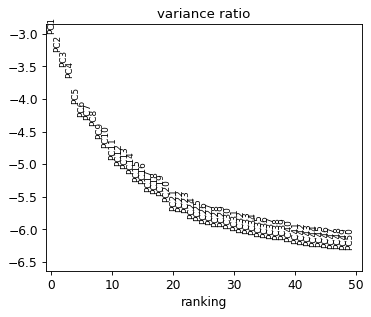

In [154]:
adata.obsm['prev_X_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']

sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)

In [155]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=25)
sc.tl.leiden(adata,resolution=1)
sc.tl.draw_graph(adata)

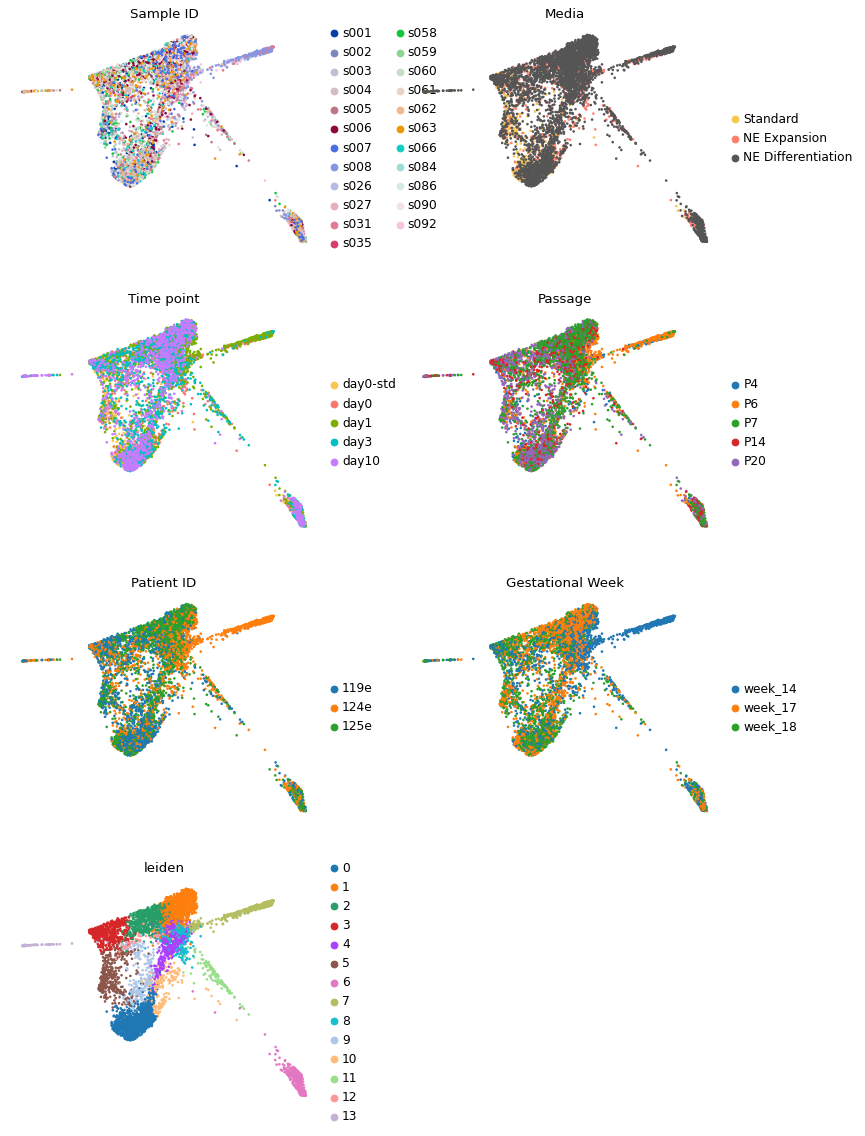

In [156]:
adata.uns['Time point_colors']=time_colours
sc.pl.draw_graph(adata, color=['Sample ID','Media',
                         'Time point','Passage',
                        'Patient ID', 'Gestational Week','leiden'],
                 ncols=2,save='_Std_NE_Exp_Diff_harmonized')

# Figure S3A

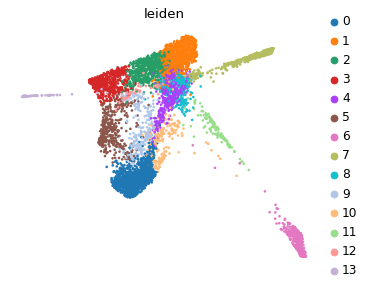

In [14]:
## Figure S3A
sc.pl.draw_graph(adata, color=['leiden'],save='_Std_NE_Exp_Diff_leiden')

# Figure S3C

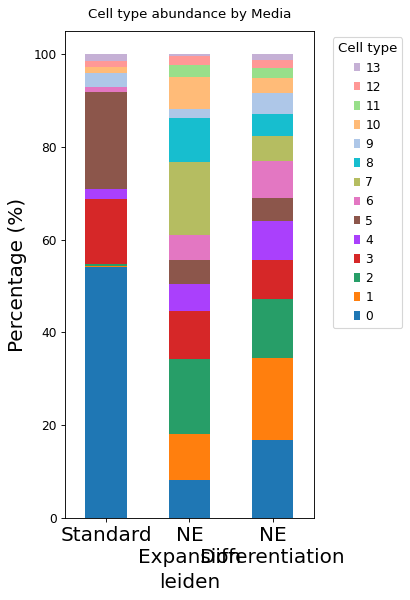

In [26]:
## Figure S1C

column_1 = adata.obs['leiden']
column_2 = adata.obs['Media']
# Create a DataFrame using the extracted columns
df = pd.DataFrame({'leiden': column_1,
                   'Media': column_2,})

fig, ax = plt.subplots(figsize=(4, 8))

# Group by and calculate the percentage of each category
grouped_df = df.groupby('Media')['leiden'].value_counts(normalize=True).unstack(fill_value=0) * 100
grouped_df = grouped_df.reset_index().set_index('Media')
order = ['Standard','NE Expansion','NE Differentiation']
grouped_df = grouped_df.loc[order]

# Plot the bar chart
ax = grouped_df.plot(kind='bar', stacked=True, alpha=1,color=adata.uns['leiden_colors'],ax=ax)

# Customize the plot
plt.title('Cell type abundance by Media',pad=12)
plt.xlabel('leiden',size=18, labelpad=6)
plt.ylabel('Percentage (%)', size=18,labelpad=6)
plt.xticks(rotation=0,size=18)
ax.set_xticklabels([label.replace(' ', '\n') for label in grouped_df.index], size=18)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Cell type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Force each patch to have no edge
for patch in ax.patches:
    patch.set_edgecolor('none')

plt.savefig(os.path.join(figfolder,'StackedPlot_fAOs_leiden_media'),
            bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

# Figure S3B

In [6]:
#adata.uns['log1p']["base"] = None
sc.tl.rank_genes_groups(adata,groupby='leiden',method='wilcoxon',pts=True,key_added='leiden_DEG')

In [14]:
for leiden in adata.obs['leiden'].unique():
    leiden_DEG = sc.get.rank_genes_groups_df(
        adata,
        group=leiden,
        key='leiden_DEG'
    )
    filename = f"./../data/markers/leiden_{leiden}_DEG.csv"
    leiden_DEG.to_csv(filename, index=False)

In [7]:
output_file = "./../data/markers/leiden_DEG.xlsx"

with pd.ExcelWriter(output_file, engine="xlsxwriter") as writer:
    for leiden in adata.obs['leiden'].unique():
        leiden_DEG = sc.get.rank_genes_groups_df(
            adata,
            group=leiden,
            key='leiden_DEG'
        )
        
        # Excel sheet names must be <= 31 characters
        sheet_name = f"leiden_{leiden}"[:31]
        leiden_DEG.to_excel(writer, sheet_name=sheet_name, index=False)


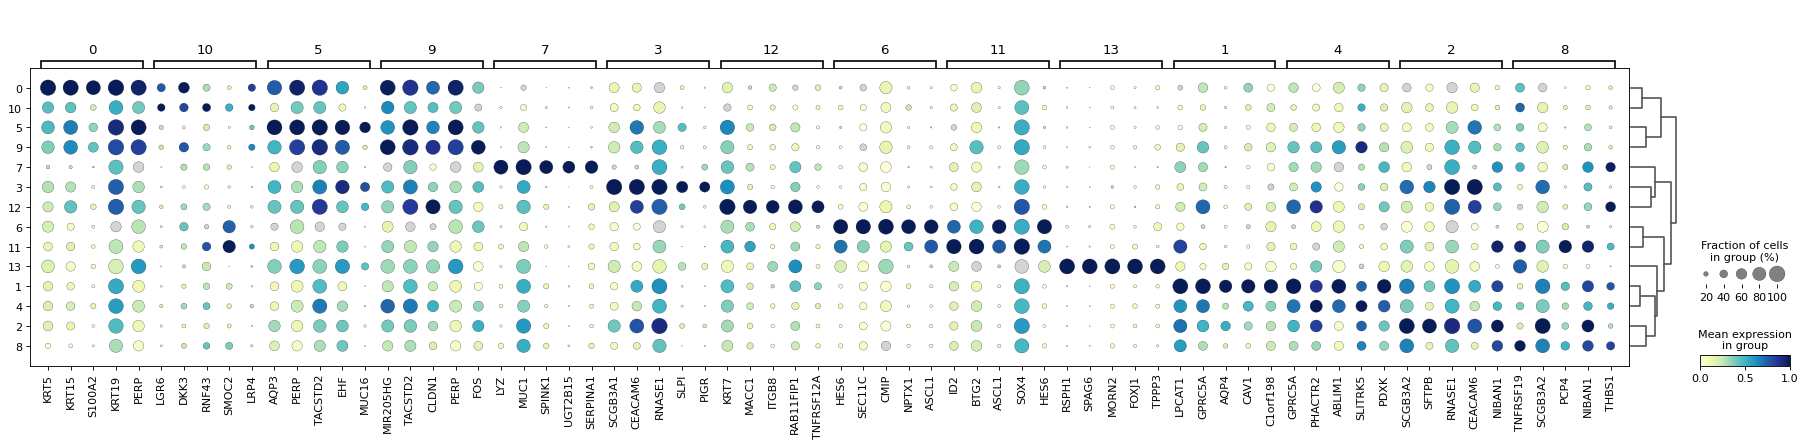

In [46]:
## Figure S3B
sc.tl.dendrogram(adata,'leiden', n_pcs=30)
sc.pl.rank_genes_groups_dotplot(adata,n_genes=5,key='leiden_DEG',cmap=cmap,standard_scale='var',
                                min_logfoldchange=1,vmin=0,save='_Std_NE_Exp_Diff_leiden_markers')

# Write Adata

In [158]:
adata.write_h5ad(
    './../data/NEr_fAOs_batch_corrected.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

In [159]:
#Inspect Matrices
matrix_summary(adata)

Expression matrix (X): min=-4.794265270233154, max=5.643955707550049, mean=9.511085252711382e-10


Counts layer matrix (layers['counts']): min=0.0, max=150.0, mean=0.2390950471162796


Raw matrix (raw.X): min=0.0, max=6.779815196990967, mean=0.11133979260921478
Scaled layer matrix (layers['scaled']): min=-13.424216270446777, max=73.74729919433594, mean=1.9892476554872474e-09


# Celltypist

In [5]:
adata=sc.read_h5ad('./../data/NEr_fAOs_batch_corrected.h5ad')
adata

AnnData object with n_obs × n_vars = 5441 × 32191
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Gestational Week_colors', 'Media_colors', 'Passage_colors', 'Patient ID_colors', 'Sample ID_colors', 'Time point_colors', 'draw_graph', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_pca_harmony', 'prev_X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'counts', 'scaled', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [9]:
predictions = celltypist.annotate(adata, model = './../data/Celltypist/celltypist_costum_models/Human_Lung_celltype.pkl',   
                                  mode = 'best match',majority_voting = True)

INFO:celltypist.logger:👀 Invalid expression matrix in `.X`, expect log1p normalized expression to 10000 counts per cell; will try the `.raw` attribute
INFO:celltypist.logger:🔬 Input data has 5441 cells and 32191 genes
INFO:celltypist.logger:🔗 Matching reference genes in the model
INFO:celltypist.logger:🧬 2874 features used for prediction
INFO:celltypist.logger:⚖️ Scaling input data
INFO:celltypist.logger:🖋️ Predicting labels
INFO:celltypist.logger:✅ Prediction done!
INFO:celltypist.logger:👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
INFO:celltypist.logger:⛓️ Over-clustering input data with resolution set to 10
INFO:celltypist.logger:🗳️ Majority voting the predictions
INFO:celltypist.logger:✅ Majority voting done!


In [10]:
predictions

CellTypist prediction result for 5441 query cells
    predicted_labels: data frame with 3 columns ('predicted_labels', 'over_clustering', 'majority_voting')
    decision_matrix: data frame with 5441 query cells and 22 cell types
    probability_matrix: data frame with 5441 query cells and 22 cell types
    adata: AnnData object referred

In [11]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata(insert_prob = True)
adata.obs['majority_voting']

s003.1              Basal
s003.2      Multiciliated
s003.3              Basal
s003.4              Basal
s003.5              Basal
                ...      
s007.152            Basal
s007.154              RAS
s007.155              RAS
s007.156            Basal
s007.157            Basal
Name: majority_voting, Length: 5441, dtype: category
Categories (9, object): ['AT1', 'Basal', 'Bud Tip Adjacent', 'Goblet', ..., 'Multiciliated', 'PNEC', 'RAS', 'Secretory']

In [12]:
adata.obs['CELLTYPIST']=adata.obs['majority_voting']

category_mapping = {
    'Ciliated': 'Multiciliated',
    'Deuterosomal': 'Multiciliated',
    'Goblet-like Secretory': 'Goblet'
}

# Apply the mapping to the 'CELL_TYPE' column
adata.obs['CELLTYPIST'] = adata.obs['CELLTYPIST'].replace(category_mapping)

# If the column is categorical, you might need to update the categories
if adata.obs['CELLTYPIST'].dtype.name == 'CELLTYPIST':
    adata.obs['CELLTYPIST'].cat.categories = adata.obs['adata'].cat.categories.map(lambda x: category_mapping.get(x, x))

category_counts = adata.obs['CELLTYPIST'].value_counts()
category_counts

Basal               2019
RAS                 1994
AT1                  506
PNEC                 363
Goblet               274
Bud Tip Adjacent     161
Secretory             63
Multiciliated         61
Name: CELLTYPIST, dtype: int64

In [12]:
adata.obs['CELLTYPIST_Media']=adata.obs['CELLTYPIST'].astype(str) + '_' + adata.obs['Media'].astype(str)

category_counts = adata.obs['CELLTYPIST_Media'].value_counts()
category_counts

RAS_NE Differentiation                 1505
Basal_NE Differentiation               1302
Basal_Standard                          502
AT1_NE Differentiation                  479
RAS_NE Expansion                        407
PNEC_NE Differentiation                 313
Basal_NE Expansion                      215
Goblet_NE Differentiation               169
Bud Tip Adjacent_NE Differentiation     117
Goblet_NE Expansion                      92
RAS_Standard                             82
Multiciliated_NE Differentiation         49
PNEC_NE Expansion                        44
Bud Tip Adjacent_NE Expansion            43
Secretory_NE Differentiation             34
AT1_NE Expansion                         25
Secretory_Standard                       16
Secretory_NE Expansion                   13
Goblet_Standard                          13
Multiciliated_Standard                    9
PNEC_Standard                             6
Multiciliated_NE Expansion                3
AT1_Standard                    

In [15]:
adata.uns['CELLTYPIST_colors']=[
    '#1f78b4',  # Basal
    '#ff7f00',  # RAS
    '#e31a1c',  # AT1
    '#9467bd',  # PNEC
    '#b15928',  # Goblet
    '#17becf',  # Bud Tip Adjacent 
    '#33a02c',  # Secretory
    '#e377c2',  # Multiciliated
]

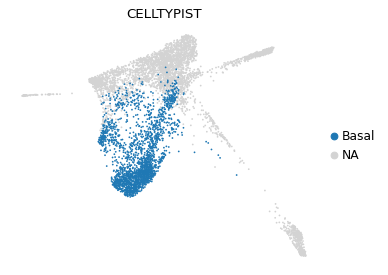

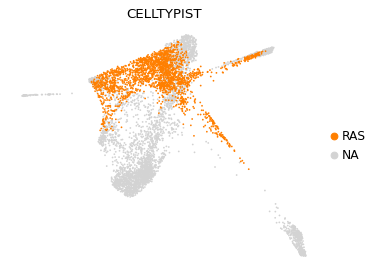

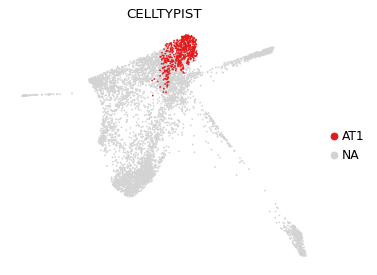

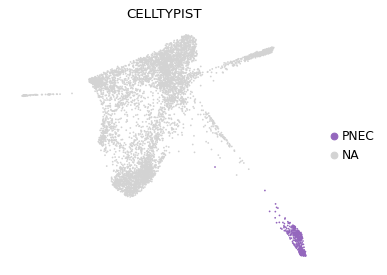

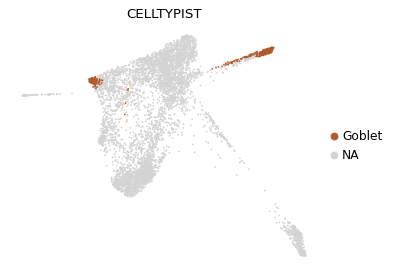

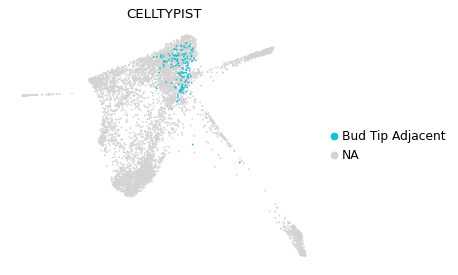

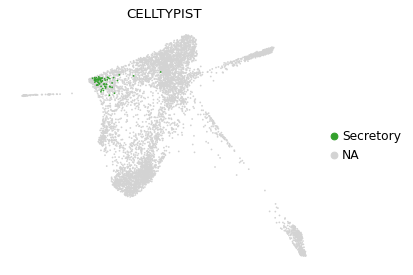

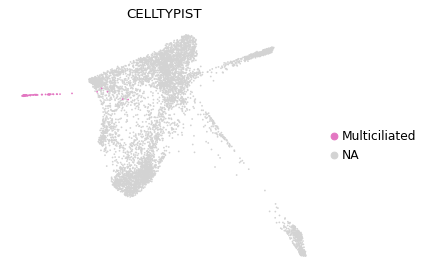

In [16]:
category_counts = adata.obs['CELLTYPIST'].value_counts()
sorted_categories = category_counts.index.to_list()
adata.obs['CELLTYPIST'] = pd.Categorical(adata.obs['CELLTYPIST'], categories=sorted_categories, ordered=True)
sorted_categories

for celltype in sorted_categories:
    sc.pl.draw_graph(adata,color=['CELLTYPIST'],size=10,groups=celltype)

# Figure S3E

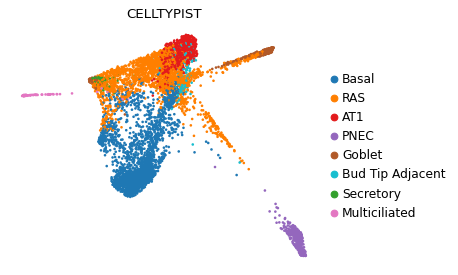

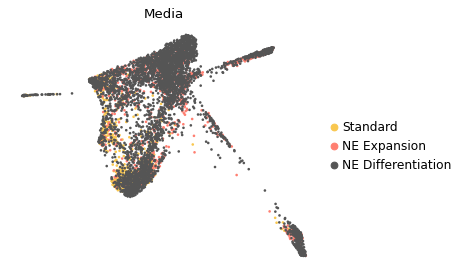

In [17]:
## Figure S3E
sc.pl.draw_graph(adata,use_raw=True, color=['CELLTYPIST'],save='_Std_NE_Exp_Diff_CELLTYPIST')

In [ ]:
sc.pl.draw_graph(adata,use_raw=True, color=['Media'])

# Figure S3I

In [19]:
adata.obs['CELLTYPIST_media'] = ''

for i in adata.obs.index:
    adata.obs.loc[i, 'CELLTYPIST_media'] = adata.obs.loc[i, 'CELLTYPIST'] + ' (' + adata.obs.loc[i, 'Media'] + ')'

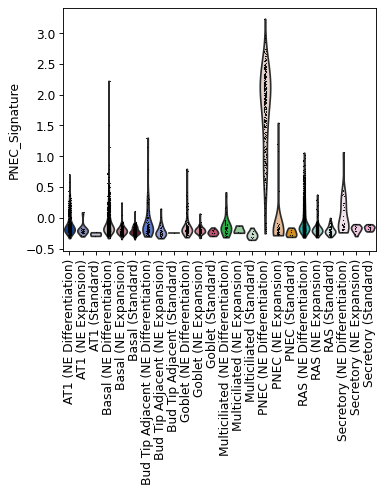

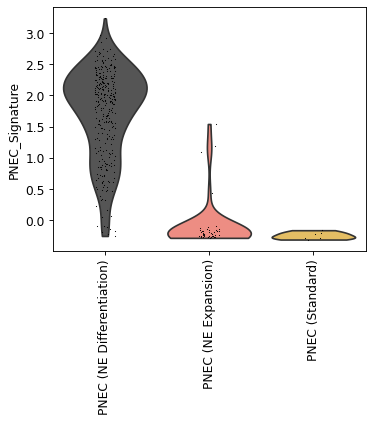

In [28]:
NE_markers=['ASCL1','CHGA','UCHL1','GRP']
sc.tl.score_genes(adata,NE_markers,score_name="PNEC_Signature",use_raw=True)
sc.pl.violin(adata,'PNEC_Signature',use_raw=True, groupby='CELLTYPIST_media',rotation=90)

# Figure S3I
sc.pl.violin(adata,'PNEC_Signature',use_raw=True, groupby='CELLTYPIST_media',rotation=90,
             order=['PNEC (NE Differentiation)','PNEC (NE Expansion)','PNEC (Standard)'],
             palette=['#555555','#FF7F71','#F9C74F'],
             save='_PNEC_signature_media')

# Write Adata

In [29]:
adata.write_h5ad(
    './../data/NEr_fAOs_annotated.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

In [8]:
adata=sc.read_h5ad('./../data/NEr_fAOs_annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 5441 × 32191
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'S_score', 'G2M_score', 'phase', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'CELLTYPIST', 'PNEC_Signature', 'CELLTYPIST_media', 'CELL_TYPE'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CELLTYPIST_colors', 'CELLTYPIST_media_colors', 'CE

## Figure S4D

In [17]:
# Create a boolean mask based on your condition
condition_mask = (adata.obs['Time point'].isin(['day10']))
adata_d10 = adata[condition_mask]
cells_ID = adata_d10.obs_names
adata_d10

View of AnnData object with n_obs × n_vars = 1158 × 32191
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'S_score', 'G2M_score', 'phase', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'CELLTYPIST', 'PNEC_Signature', 'CELLTYPIST_media', 'CELL_TYPE'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CELLTYPIST_colors', 'CELLTYPIST_media_colo

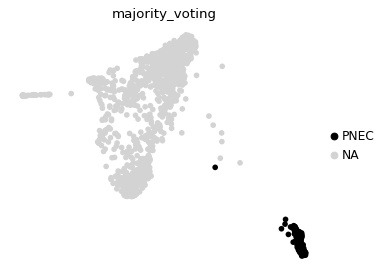

In [18]:
## Figure S4D
sc.pl.draw_graph(adata_d10, color='majority_voting', groups=['PNEC'], palette=['black'],save='_NEr-fAOs_d10_celltypist_Neuroendocrine')